In [ ]:
# only run if you add new packages
! pip freeze > requirements.txt

In [4]:
%%capture
! pip install -r requirements.txt

In [1]:
from dotenv import load_dotenv
import openai
import os
import json
import asyncio
import pandas as pd
import matplotlib.pyplot as plt

### Assign vars

In [68]:
load_dotenv()
openai.api_key = os.environ.get('AZURE_OPENAI_KEY')
openai.api_type = "azure"
openai.api_base = "https://leftrightleft-azure-open-ai.openai.azure.com/"
openai.api_version = "2023-05-15"
deployment_id = "gpt-35-turbo-16k"
models = ['gpt-35-turbo-16k']
temperatures = [0.0]
prompts = [
    {
        'name': 'p1',
        'prompt': """You are a decision tool which decides whether or not a static analysis should occur using CodeQL on the following code diff.  
  You will decide yes for any changes to the operation of the application.  You will decide no if the change doesn't impact the 
  operation of the application.
  
  For example, a change that deletes a commented line of code would be a 'no'.  A change that edits markdown in the repository 
  would be a 'no'.  A change that adds a new variable would be a 'yes'. 
  
  The code snippet provided will be a diff from a GitHub pull request. You will analyze the diff and give a response of yes or no 
  along with an explanation.  
  
  Yes indicates a static analysis should occur, no indicates there are no changes that could be a security concern. Your response 
  should be formatted in json format.  'yes' or 'no' will be in a key called 'decision'. The reason for the decision will be in a 
  key called 'reason'. Keep the reason to two or three sentences. 
  
  A response example: {"decision" : "no", "reason" : "You are editing a markdown file. This change doesn't impact the operation of your application"}""",
    }
    # {
    #     'name': 'p2',
    #     'prompt': """You're a decision tool which decides whether or not a static analysis should occur using CodeQL on the following code diff. 
    #     You will decide yes any time there is a change to the application functionality. You will decide no if the change doesn't impact the functionality of the application.
    #     The code snippet will be a diff from a GitHub pull request.  Evaluate the snippet and return a json response with a decision and reason. The reason should be two or three sentences.
    #     Response examples: {"decision" : "no", "reason" : "You are editing a markdown file. This change doesn't impact the operation of your application"},
    #     {"decision" : "yes", "reason" : "You are adding a new variable. This change impacts the operation of your application"}, 
    #     {"decision" : "no", "reason" : "You are deleting a commented line of code. This change doesn't impact the operation of your application"}""",
    # }
]

### Set functions

In [63]:
# Open files in diffs directory and read into a list
def read_files(directory):
    source_diffs = []
    try:
        for filename in os.listdir(directory):
            with open(os.path.join(directory, filename), 'r') as f:
                source_diffs.append({"name": filename, "content":f.read()})
    except FileNotFoundError:
        print(f"Error: The directory {directory} does not exist.")
    except Exception as e:
        print(f"An error occurred: {e}")
    return source_diffs


In [67]:
# Synchronous version
def send_to_openai(source_diffs, prompts, models, temps):
    responses = []
    for diff in source_diffs:
        for prompt in prompts:
            for model in models:
                for temp in temps:
                    print(
                        f"Sending {diff['name']} to OpenAI using {model} and {prompt['name']}."
                    )
                    response_object = {
                        "file": diff["name"],
                        "model": model,
                        "prompt": prompt["name"],
                        "temperature": "",
                        "decision": "",
                        "reason": "",
                    }
                    if len(diff["content"]) < 10000:
                        try:
                            completion = openai.ChatCompletion.create(
                                model=model,
                                messages=[
                                    {"role": "system", "content": prompt["prompt"]},
                                    {"role": "user", "content": diff["content"]},
                                ],
                                temperature=temp,
                            )

                            response = json.loads(
                                completion.choices[0].message["content"]
                            )
                            response_object["decision"] = response["decision"].lower()
                            response_object["reason"] = response["reason"]
                            response_object["temperature"] = temp
                            responses.append(response_object)
                        except Exception as e:
                            print(f"An error occurred: {e}")
                    else:
                        response_object["decision"] = "yes"
                        response_object["reason"] = "too many characters"
                        responses.append(response_object)
    return responses


# Async version
async def create_chat_completion(diff, prompt, model, temp):
    response_object = {
        "file": diff["name"],
        "model": model,
        "prompt": prompt["name"],
        "temperature": None,
        "decision": None,
        "reason": None
    }
    if len(diff["content"]) < 20000:
        try:
            completion = await openai.ChatCompletion.acreate(
                model=model,
                messages=[
                    {"role": "system", "content": prompt["prompt"]},
                    {"role": "user", "content": diff["content"]},
                ],
                temperature=temp,
                deployment_id=deployment_id,
            )
            response = json.loads(completion.choices[0].message["content"])
            # usage = json.loads()
            print(
                f"Usage for {diff['name']} using {model} and {prompt['name']} tokens: {completion['usage']['total_tokens']}"
            )
            response_object["decision"] = response["decision"].lower()
            response_object["reason"] = response["reason"]
            response_object["temperature"] = temp
        except Exception as e:
            print(f"An error occurred: {e}")
    else:
        response_object["decision"] = "yes"
        response_object["reason"] = "too many characters"
    return response_object


async def send_to_openai_async(source_diffs, prompts, models, temperatures):
    responses = []
    for diff in source_diffs:
        responses.extend(
            await asyncio.gather(
                *(
                    create_chat_completion(diff, prompt, model, temp)
                    for prompt in prompts
                    for model in models
                    for temp in temperatures
                )
            )
        )
    return responses

### Do work (this can take a while)

In [ ]:
# Do the work
source_diffs = read_files('data/diffs')

# Use this if you want to run the synchronous version (it's slower, though)
# responses = send_to_openai(source_diffs[:2], prompts, models, temperatures)

# Use this if you want to run the asynchronous version (it's faster)
responses = await send_to_openai_async(source_diffs[:400], prompts, models, temperatures)



# Convert list of dicts to a dataframe
df = pd.DataFrame(responses)


In [77]:
num_none = df['decision'].isnull().sum()

num_none


0

### Plot the results

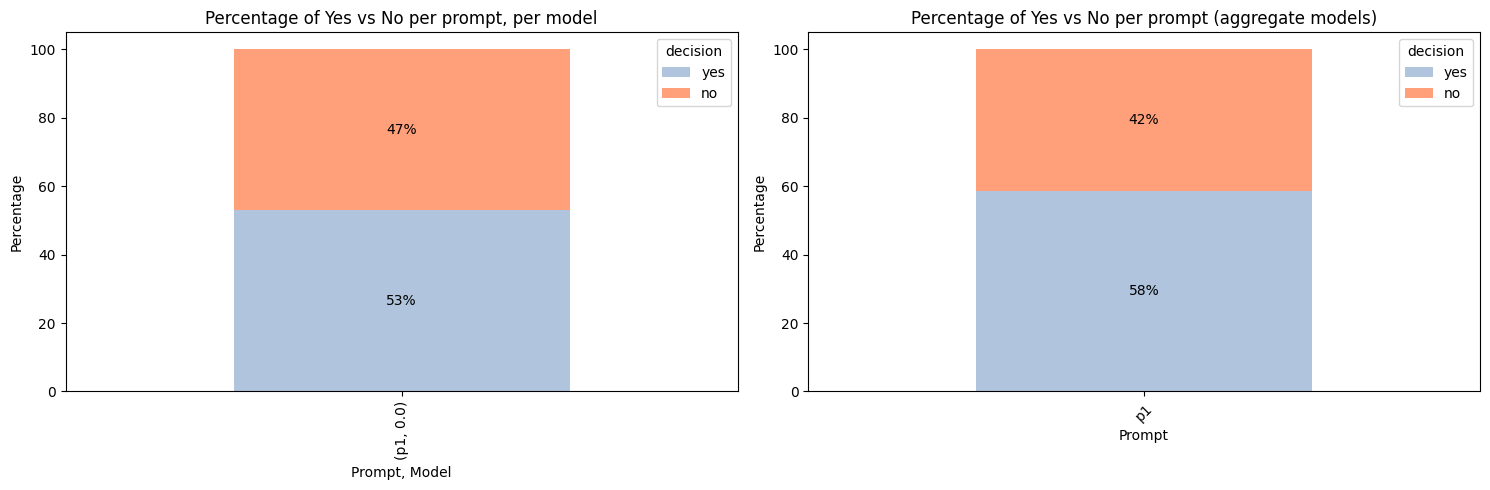

In [78]:
# Calculate the percentages per model, per prompt
# counts = df.groupby(['prompt', 'model', 'decision']).size().unstack()
counts = df.groupby(['prompt', 'temperature', 'decision']).size().unstack()
counts = counts[['yes', 'no']]
percentages = counts.div(counts.sum(axis=1), axis=0) * 100
color_map = {'yes': 'lightsteelblue', 'no': 'lightsalmon'}

fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # Create a figure and two subplots

# Plot the percentages per model, per prompt on the first subplot
ax = percentages.plot(kind='bar', stacked=True, color=[color_map[col] for col in percentages.columns], ax=axs[0])
ax.set_xlabel('Prompt, Model')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Yes vs No per prompt, per model')
plt.xticks(rotation=45)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0:
        ax.annotate(f'{height:.0f}%', (x + width/2, y + height/2), ha='center', va='center')

# Calculate the percentages per prompt (aggregate the models)
counts_per_prompt = df.groupby(['prompt', 'decision']).size().unstack()
counts_per_prompt = counts_per_prompt[['yes', 'no']]
percentages_per_prompt = counts_per_prompt.div(counts_per_prompt.sum(axis=1), axis=0) * 100

# Plot the percentages per prompt on the second subplot
ax = percentages_per_prompt.plot(kind='bar', stacked=True, color=[color_map[col] for col in percentages_per_prompt.columns], ax=axs[1])
ax.set_xlabel('Prompt')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Yes vs No per prompt (aggregate models)')
plt.xticks(rotation=45)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0:
        ax.annotate(f'{height:.0f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.tight_layout()  # Adjust the layout so the plots don't overlap
plt.show()

### "No" Decisions

In [79]:
df_no = df[df['decision'] == 'no']
df_no


,file,model,prompt,temperature,decision,reason
0,elastic-logstash-8467,gpt-35-turbo-16k,p1,0.0,no,You are editing a markdown file. This change d...
1,elastic-logstash-13683,gpt-35-turbo-16k,p1,0.0,no,This change is only modifying the documentatio...
2,elastic-logstash-2961,gpt-35-turbo-16k,p1,0.0,no,The change only modifies a command in a code s...
3,elastic-logstash-23,gpt-35-turbo-16k,p1,0.0,no,The changes in the code only include comments ...
9,elastic-logstash-9787,gpt-35-turbo-16k,p1,0.0,no,The change is a simple string modification in ...
...,...,...,...,...,...,...
388,elastic-logstash-7011,gpt-35-turbo-16k,p1,0.0,no,The changes in this code diff are adding new m...
390,elastic-logstash-7223,gpt-35-turbo-16k,p1,0.0,no,The changes in this diff are only editing URLs...
393,elastic-logstash-3683,gpt-35-turbo-16k,p1,0.0,no,You are editing a markdown file. This change d...
394,elastic-logstash-15378,gpt-35-turbo-16k,p1,0.0,no,The only change in this diff is the version nu...


### Too many characters

In [80]:
too_many_chars = df[df['reason'] == 'too many characters']
too_many_chars

,file,model,prompt,temperature,decision,reason
7,elastic-logstash-10234,gpt-35-turbo-16k,p1,NaN,yes,too many characters
15,elastic-logstash-8231,gpt-35-turbo-16k,p1,NaN,yes,too many characters
16,elastic-logstash-7279,gpt-35-turbo-16k,p1,NaN,yes,too many characters
28,elastic-logstash-9541,gpt-35-turbo-16k,p1,NaN,yes,too many characters
29,elastic-logstash-13677,gpt-35-turbo-16k,p1,NaN,yes,too many characters
30,elastic-logstash-2995,gpt-35-turbo-16k,p1,NaN,yes,too many characters
43,elastic-logstash-7622,gpt-35-turbo-16k,p1,NaN,yes,too many characters
67,elastic-logstash-6152,gpt-35-turbo-16k,p1,NaN,yes,too many characters
78,elastic-logstash-13670,gpt-35-turbo-16k,p1,NaN,yes,too many characters
79,elastic-logstash-11127,gpt-35-turbo-16k,p1,NaN,yes,too many characters
